## Сравнение uniform и Xavier uniform на MNIST

In [2]:
import torch 
import torchvision
import tqdm as notebook_tqdm
import torch.nn as nn

/Users/kodin/.pyenv/versions/3.8.13/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Загрузка данных

In [114]:
from torchvision import datasets as dts
from torchvision.transforms import ToTensor 


batch_size_train = 64
batch_size_test = 1000

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [115]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

### Смотрим на данные 

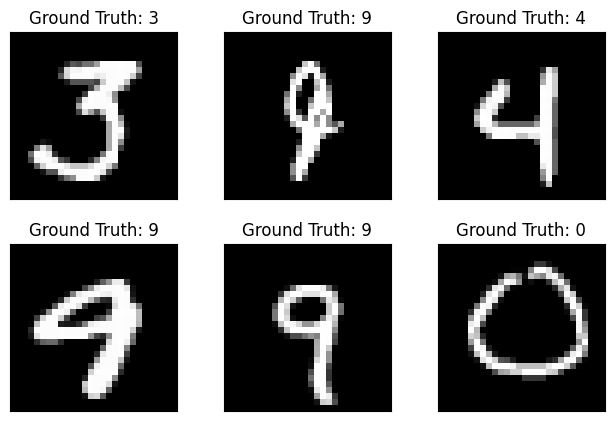

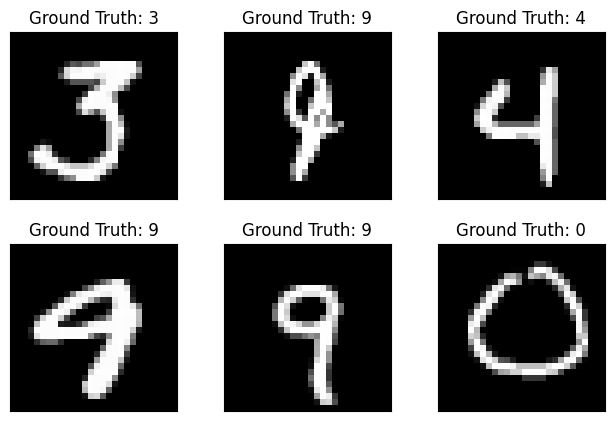

In [116]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [117]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import sqrt

### Модель с  uniform 

In [118]:

# созадем модель классивфикации изображений
class model_usual(nn.Module):
    def __init__(self):
        super( model_usual,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 100) 
        self.linear3 = nn.Linear(100, 100) 
        self.linear4 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)

        nn.init.uniform_(self.linear1.weight, 0, 1/sqrt(5))
        nn.init.uniform_(self.linear2.weight, 0, 1/sqrt(5))
        nn.init.uniform_(self.linear3.weight, 0, 1/sqrt(5))
        nn.init.uniform_(self.linear4.weight, 0, 1/sqrt(5))
        
        self.tanh = nn.Tanh()

    def forward(self, image):
        a = image.view(-1, 28*28)
        a = self.tanh(self.linear1(a))
        a = self.tanh(self.linear2(a))
        a = self.tanh(self.linear3(a))
        a = self.tanh(self.linear4(a))
        a = self.final(a)
        return F.log_softmax(a)

model = model_usual()
print(model)

model_usual(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (tanh): Tanh()
)


#### Обучение

In [119]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:

# обучаем 
EPOCH = 30
train_losses = []
train_counter = []
epoch_counter = []
epoch_losses = []

min_loss_epoch = 100

count = 0

for e in range(EPOCH):
  epoch_counter.append(e)
  min_loss_epoch = 100
  for batch_idx, (data, target) in enumerate(train_loader):
    
    # фиксируем количество примеров 
    count+=1
    train_counter.append(count)
    
    optimizer.zero_grad()

    y_pred = model.forward(data)
    loss_vall =  F.nll_loss(y_pred, target)
    

    loss_vall.backward()
    optimizer.step()

    loss_vall = loss_vall.detach().numpy()

    if not (e % 1000 == 0):
      print('Loss - {}, {}/{}'.format(loss_vall, e, EPOCH))
    
    train_losses.append(loss_vall)
    if loss_vall < min_loss_epoch:
      min_loss_epoch = loss_vall
  
  # запоминаем результат эпохи
  epoch_losses.append(min_loss_epoch)

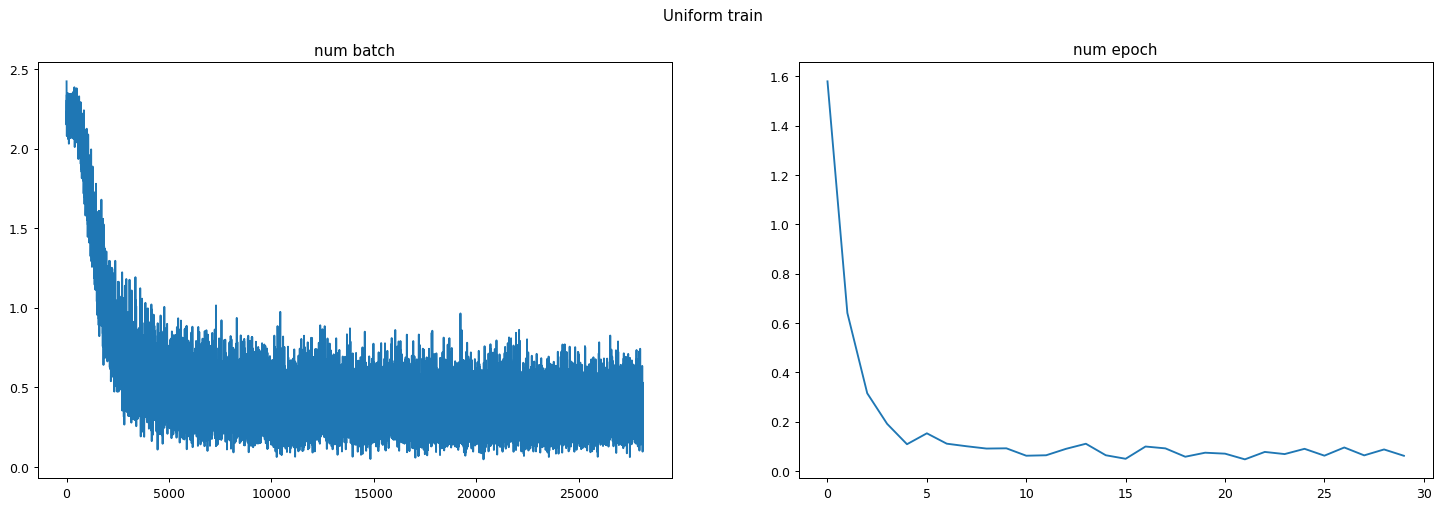

In [121]:
  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=90)

fig.suptitle('Uniform train')
ax1.set_title('num batch')
ax2.set_title('num epoch')

ax1.plot(train_counter, train_losses)
ax2.plot(epoch_counter, epoch_losses)

#### Результаты на тестовой выборке

In [ ]:
model.eval()
test_losses = []
test_loss = 0
num  = []

cur = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
      cur+=1
      num.append(cur)
      
      output = model(data)
      
      test_loss += F.nll_loss(output, target, size_average=False).item()
      
      pred = output.data.max(1, keepdim=True)[1]
      
      correct += pred.eq(target.data.view_as(pred)).sum()
      
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

### Визуализируем резульат

In [123]:
import numpy as np
def predict(model, example):
    output = model.forward(example).detach().numpy()
    return np.argmax(output)

/var/folders/tw/0xxcpj311px323qzr54yqgkr0000gn/T/ipykernel_76928/668619945.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(a)


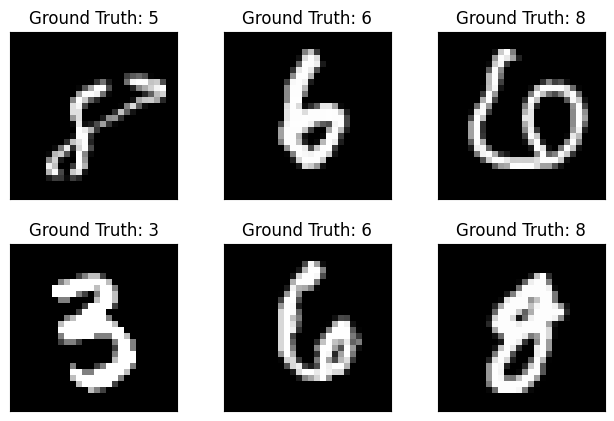

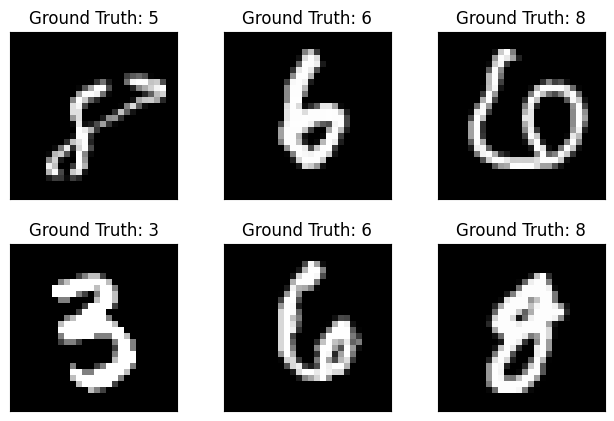

In [124]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(predict(model,example_data[i][0])))
  plt.xticks([])
  plt.yticks([])
fig

### Модель с инициализацией Xavier

In [125]:

# созадем модель классивфикации изображений
class model_xavier(nn.Module):
    def __init__(self):
        super( model_xavier,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 100) 
        self.linear3 = nn.Linear(100, 100) 
        self.linear4 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)

        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.linear4.weight)
        
        self.tanh = nn.Tanh()

    def forward(self, image):
        a = image.view(-1, 28*28)
        a = self.tanh(self.linear1(a))
        a = self.tanh(self.linear2(a))
        a = self.tanh(self.linear3(a))
        a = self.tanh(self.linear4(a))
        a = self.final(a)
        return F.log_softmax(a)

model_xavier = model_xavier()
print(model_xavier)

model_xavier(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (tanh): Tanh()
)


### Обучение

In [126]:
optimizer_x = torch.optim.Adam(model_xavier.parameters(), lr=0.005)

In [ ]:

# обучаем 
EPOCH = 30
train_losses_x = []
train_counter_x = []
epoch_counter_x = []
epoch_losses_x = []

min_loss_epoch_x = 100

count = 0

for e in range(EPOCH):
  epoch_counter_x.append(e)
  min_loss_epoch_x = 100
  for batch_idx, (data, target) in enumerate(train_loader):
    
    # фиксируем количество примеров 
    count+=1
    train_counter_x.append(count)
    
    optimizer_x.zero_grad()

    y_pred = model_xavier.forward(data)
    loss_vall =  F.nll_loss(y_pred, target)
    

    loss_vall.backward()
    optimizer_x.step()

    loss_vall = loss_vall.detach().numpy()

    if not (e % 1000 == 0):
      print('Loss - {}, {}/{}'.format(loss_vall, e, EPOCH))
    
    train_losses_x.append(loss_vall)
    if loss_vall < min_loss_epoch:
      min_loss_epoch = loss_vall
  
  # запоминаем результат эпохи
  epoch_losses_x.append(min_loss_epoch)


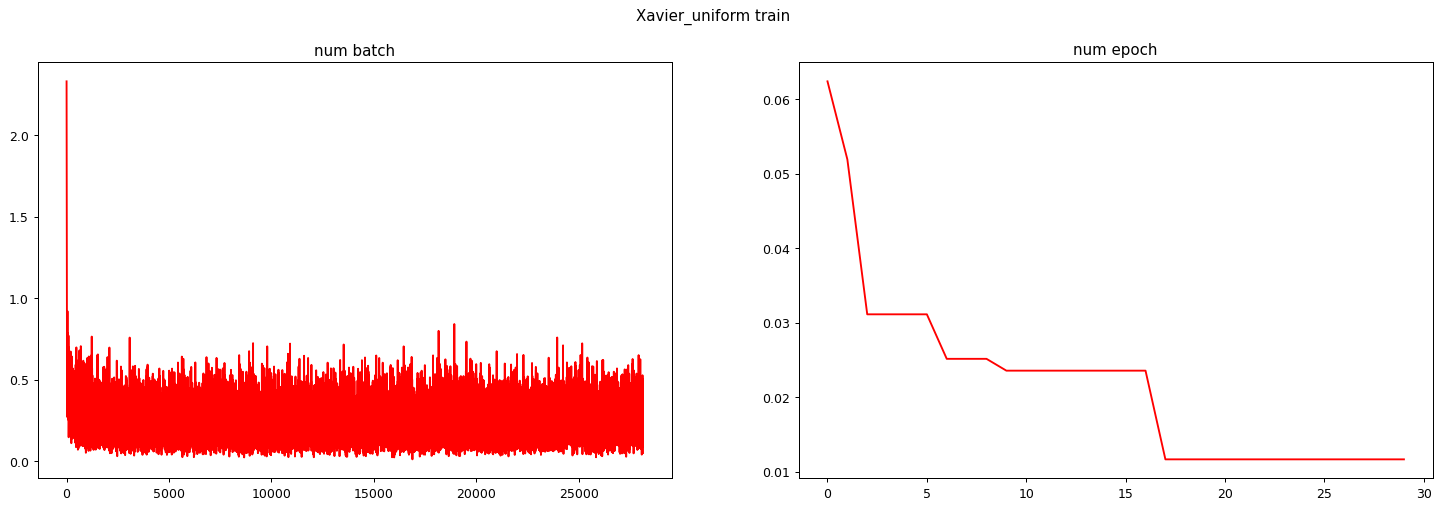

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=90)

fig.suptitle('Xavier_uniform train')
ax1.set_title('num batch')
ax2.set_title('num epoch')

ax1.plot(train_counter_x, train_losses_x, color='r')
ax2.plot(epoch_counter_x, epoch_losses_x, color='r')

### Сравниваем два метода инициализайии весов

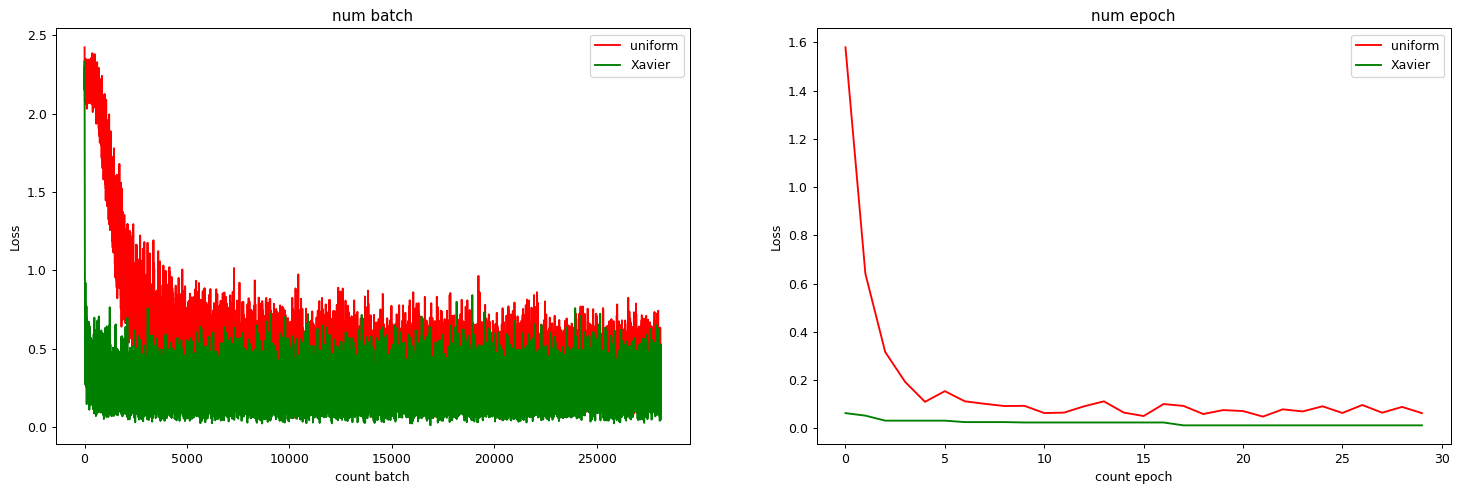

In [134]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=90)

X_x = train_counter_x
X = train_counter

y = train_losses
y_x = train_losses_x

epoch_num = epoch_counter_x
z = epoch_losses
z_x = epoch_losses_x
  
ax1.plot(X, y, color='r', label='uniform')
ax1.plot(X_x, y_x, color='g', label='Xavier')

ax2.plot(epoch_num, z, color='r', label='uniform')
ax2.plot(epoch_num, z_x, color='g', label='Xavier')  


ax1.set_title('num batch')
ax2.set_title('num epoch')

ax1.set_xlabel('count batch')
ax1.set_ylabel('Loss')

ax2.set_xlabel('count epoch')
ax2.set_ylabel('Loss')
  

ax1.legend()
ax2.legend()
plt.show()

### Видно, что с помощью метода Ксавье можно достич лучшей сходимости 

### Резултаты второй модели 

In [ ]:
model_xavier.eval()

test_losses_x = []
num = []

test_loss = 0
correct = 0
cur = 0
with torch.no_grad():
    for data, target in test_loader:
      cur+=1
      num.append(cur)
      
      output = model_xavier(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      
      test_loss /= len(test_loader.dataset)
      test_losses_x.append(test_loss)
      
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

### Визуализируем резуьтат

/var/folders/tw/0xxcpj311px323qzr54yqgkr0000gn/T/ipykernel_76928/3850764671.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(a)


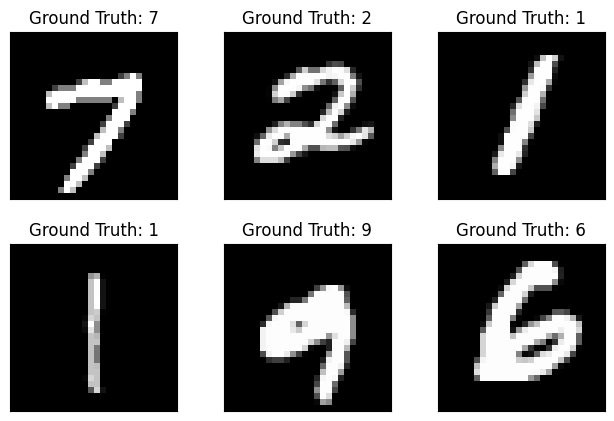

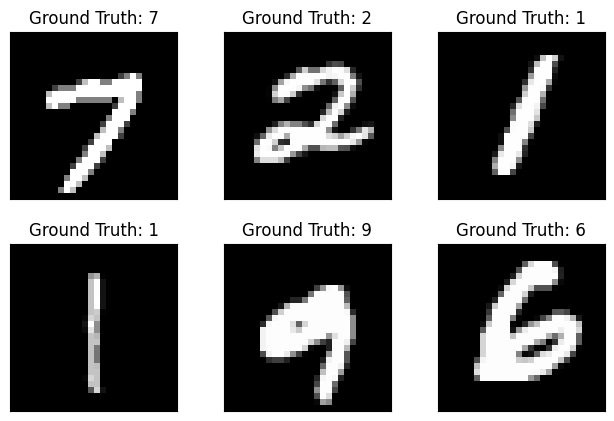

In [136]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(predict(model_xavier, example_data[i][0])))
  plt.xticks([])
  plt.yticks([])
fig